# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [6]:
# These libraries may be useful to you

from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

#import gensim
#import gensim.corpora as corpora
#from gensim.utils import simple_preprocess
#from gensim.models import CoherenceModel,LdaMulticore, Phrases 
#from gensim.models.phrases import Phraser 
#from gensim.corpora import Dictionary

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

import spacy 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict


nlp = spacy.load('en_core_web_sm')



In [41]:
# add any additional libaries you need here
#!pip install pyLDAvis
#!pip install "spacy~=3.3.1"
#!python -m spacy download en_core_web_sm

#import nltk
#nltk.download('brown')

from nltk.probability import FreqDist
from nltk.corpus import stopwords
from string import punctuation

In [73]:
# Stopwords
sw = stopwords.words("english")

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

def remove_stop(tokens) :
    # modify this function to remove stopwords
    tokens_wo_sw = []
    for w in tokens:
        if w.lower() not in sw:
            tokens_wo_sw.append(w)
    return(tokens_wo_sw)
 
def remove_punctuation(text, punct_set=tw_punct): 
    for ele in text:
        if ele in punct_set:
            text = text.replace(ele, "")
    return(text)

In [3]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [9]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [10]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [11]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<AxesSubplot:xlabel='category'>

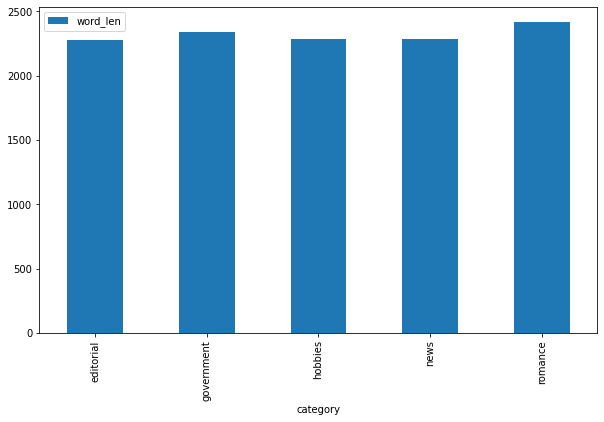

In [12]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [13]:
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

C:\Users\lenny\anaconda3\envs\my-env-for-ads509\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [14]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: count_text_vectors stores a matrix of token counts whereas tfidf_text_vectors stores a matrix of tokens relative to document importance (i.e. puts weights on more rare words so they are not overshadowed by words like "a, the, in".

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [17]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [18]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


C:\Users\lenny\anaconda3\envs\my-env-for-ads509\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

In [86]:
#find the top words in each brown category
for category in brown.categories():
    text=brown.words(categories=category)
    text = remove_stop(text)
    text = [remove_punctuation(i) for i in text]
    fdist=FreqDist(text)
    modals=fdist.most_common(6)
    print(category)
    for m in modals:
        if m[1] <= 1000:
            print(m, end=' ')
    print('\n')

adventure
('said', 287) ('would', 191) ('back', 165) ('man', 165) ('one', 162) 

belles_lettres
('one', 475) ('would', 392) ('time', 225) ('man', 219) ('could', 213) 

editorial
('would', 180) ('one', 150) ('Mr', 110) ('new', 80) ('American', 77) 

fiction
('would', 287) ('said', 192) ('one', 168) ('could', 166) ('like', 147) 

government
('year', 183) ('States', 181) ('United', 155) ('may', 153) ('would', 120) 

hobbies
('one', 258) ('may', 131) ('time', 127) ('two', 116) ('first', 114) 

humor
('said', 87) ('one', 64) ('would', 56) ('time', 43) ('even', 38) 

learned
('Af', 908) ('one', 454) ('may', 324) ('would', 319) ('1', 245) 

lore
('one', 290) ('would', 186) ('time', 174) ('may', 165) ('first', 145) 

mystery
('said', 202) ('would', 186) ('one', 166) ('back', 156) ('could', 141) 

news
('said', 402) ('Mrs', 254) ('would', 244) ('one', 184) ('Mr', 170) 

religion
('God', 131) ('world', 90) ('one', 87) ('may', 78) ('new', 77) 

reviews
('one', 106) ('Mr', 105) ('music', 68) ('fir

Q: How does your five-topic NMF model compare to the original Brown categories? 

A: <!-- Your answer here --> There is some overlap between the five-topic model and the original Brown categories as far as most common words are concerned.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

In [87]:
# Your code here
from sklearn.decomposition import TruncatedSVD

svd_para_model = TruncatedSVD(n_components = 10, random_state=42)
W_svd_para_matrix = svd_para_model.fit_transform(tfidf_text_vectors)
H_svd_para_matrix = svd_para_model.components_

In [88]:
display_topics(svd_para_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.14)
  mr (1.73)
  said (1.06)
  kennedy (0.82)
  laos (0.78)

Topic 03
  mrs (29.99)
  club (6.67)
  game (6.21)
  jr (5.71)
  dallas (5.47)

Topic 04
  game (4.46)
  league (3.20)
  baseball (3.18)
  ball (3.02)
  team (2.91)

Topic 05
  mrs (4.51)
  music (1.15)
  af (1.09)
  khrushchev (1.04)
  miss (0.98)

Topic 06
  faculty (184.24)
  college (178.80)
  student (139.55)
  shall (123.17)
  university (114.98)

Topic 07
  mrs (10.11)
  sales (5.92)
  marketing (4.33)
  billion (4.33)
  business (4.01)

Topic 08
  state (26.37)
  states (18.26)
  united (16.73)
  shall (15.81)
  mrs (15.67)

Topic 09
  shall (19.61)
  united (17.02)
  board (14.47)
  states (11.02)
  court (10.58)


Q: How does your five-topic LSA model compare to the original Brown categories? 

A: <!-- Your answer here --> There is again overlap between the top words of the LSA model and the top words of the brown categories.

Q: What is your interpretation of the display topics output? 

A: It shows the top words of each topic and the percentage the word was used

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [92]:
# Fit your LDA model here
from sklearn.decomposition import LatentDirichletAllocation

lda_text_model = LatentDirichletAllocation(n_components = 10, random_state=42)
W_lda_para_matrix = lda_text_model.fit_transform(tfidf_text_vectors)
H_lda_para_matrix = lda_text_model.components_

In [93]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  didn (0.33)
  eyes (0.27)
  looked (0.25)
  wasn (0.22)
  couldn (0.22)

Topic 01
  baseball (0.22)
  dallas (0.22)
  runs (0.17)
  roy (0.14)
  vernon (0.14)

Topic 02
  seventeen (0.02)
  spirits (0.02)
  simpson (0.02)
  insert (0.02)
  injured (0.02)

Topic 03
  seventeen (0.02)
  spirits (0.02)
  simpson (0.02)
  insert (0.02)
  injured (0.02)

Topic 04
  susan (0.13)
  jim (0.09)
  charlie (0.09)
  pete (0.09)
  widow (0.04)

Topic 05
  said (0.33)
  mr (0.20)
  state (0.18)
  mrs (0.17)
  president (0.14)

Topic 06
  dave (0.08)
  anne (0.02)
  pete (0.02)
  plays (0.02)
  wildlife (0.02)

Topic 07
  game (0.23)
  ball (0.22)
  player (0.21)
  pool (0.19)
  shooting (0.18)

Topic 08
  seventeen (0.02)
  spirits (0.02)
  simpson (0.02)
  insert (0.02)
  injured (0.02)

Topic 09
  alexander (0.02)
  seventeen (0.02)
  spirits (0.02)
  simpson (0.02)
  insert (0.02)


Q: What inference do you draw from the displayed topics for your LDA model? 

A: <!-- Your answer here --> It seems to line up with the same topics from brown categories.


Q: How does your five-topic LDA model compare to the original Brown categories? 

A: <!-- Your answer here --> Again, we can see some overlap between the top words of each topic/cateogry.

In [94]:
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

C:\Users\lenny\anaconda3\envs\my-env-for-ads509\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [95]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: <!-- Your answer here --> The most used words are very formal.  This makes sense since the corpus came from articles written on various topics.  Said, Mr, Mrs, being some of the top words is an obvious sign of a report style of text.
